# Process : GlobalView - zonal
_process GlobalView xCO2 data_

- **Original**: `/local/data/artemis/observations/globalview/originals`
- **Processed**: `/local/data/artemis/observations/globalview/processed/`
- **Variable**: xCO2
- **Temporal**: Monthly, 198201 - 201712
- **Spatial**: 1x1 degree, interpolated from native grid

This script processes the GLOBALVIEW xCO2 data. 
This is zonally averaged data. 

Last update : 20 September 2019 L. Gloege

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Future versions of pandas will require you to explicitly register matplotlib converters
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Observations directory
dir_obs = '/local/data/artemis/observations'

In [3]:
# Surface file
fl = f'{dir_obs}/globalview/originals/co2_GHGreference.645082325_zonal.txt'

In [4]:
df = pd.read_csv(fl, sep='\s+', skiprows=73, header=None, index_col=3)

In [5]:
df.head()

,0,1,2,4,5
3,,,,,
1979.000000,1979,1,1,336.0797,0.1736
1979.020833,1979,1,8,336.3130,0.1786
1979.041667,1979,1,16,336.5460,0.1777
1979.062500,1979,1,23,336.7642,0.1697
1979.083333,1979,1,31,336.9569,0.1578


In [17]:
# Time vector
df_time = pd.DataFrame({'year': df[0].values,
                        'month': df[1].values,
                        'day': df[2].values})
time = pd.to_datetime(df_time)

In [25]:
# xCO2 
xco2 = df[4]
xco2_uncert = df[5]

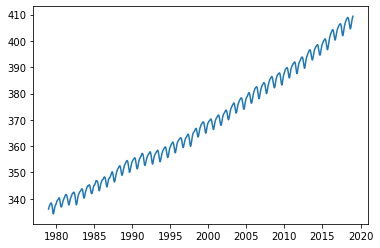

In [20]:
plt.plot(time, xco2)

## Create NetCDF File of raw data
the NOAA MLB product uses ~weekly data. there are 48 equal time steps each year (~7.6 days)

In [55]:
ds_out = xr.Dataset(
    {
    'xco2':(['time'], xco2, 
            {'long_name':'mixing ratio of atmospheric CO2',
            'units':'ppmv'}),
    'xco2_uncertainty':(['time'], xco2_uncert, 
            {'long_name':'mixing ratio of atmospheric CO2 uncertainty',
            'units':'ppmv'}),
     'year' : (['time'], df[0].values,
              {'long_name':'years'}),
     'month' : (['time'], df[1].values,
              {'long_name':'month'}),
     'day' : (['time'], df[2].values,
              {'long_name':'days'})
    },

    coords={
    'time': (['time'], time)
    },
    attrs={'contact':'Luke Gloege (gloege@ldeo.columbia.edu)',
           'creation_date':'21 September 2019',
           'notes':'raw data was not manipulated',
           'original_data':'https://www.esrl.noaa.gov/gmd/ccgg/mbl/'})

In [56]:
ds_out.info()

xarray.Dataset {
dimensions:
	time = 1921 ;

variables:
	float64 xco2(time) ;
		xco2:long_name = mixing ratio of atmospheric CO2 ;
		xco2:units = ppmv ;
	float64 xco2_uncertainty(time) ;
		xco2_uncertainty:long_name = mixing ratio of atmospheric CO2 uncertainty ;
		xco2_uncertainty:units = ppmv ;
	int64 year(time) ;
		year:long_name = years ;
	int64 month(time) ;
		month:long_name = month ;
	int64 day(time) ;
		day:long_name = days ;
	datetime64[ns] time(time) ;

// global attributes:
	:contact = Luke Gloege (gloege@ldeo.columbia.edu) ;
	:creation_date = 21 September 2019 ;
	:notes = raw data was not manipulated ;
	:original_data = https://www.esrl.noaa.gov/gmd/ccgg/mbl/ ;
}

## Save native data in netcdf

In [57]:
ds_out.to_netcdf(f'{dir_obs}/globalview/processed/xco2_zonal_weekly_globalview_197901-201812.nc')

## Sample the data monthly

In [64]:
# Define Dates
dates = pd.date_range(start='1979-01-01T00:00:00.000000000', 
                      end='2018-12-01T00:00:00.000000000',freq='MS')+ np.timedelta64(14, 'D')
print(f'dates shape = {np.shape(dates)}')

dates shape = (480,)


In [68]:
ds_out_monthly = xr.Dataset(
    {
    'xco2':(['time'], ds_out['xco2'].resample(time='1MS').mean().values, 
            {'long_name':'mixing ratio of atmospheric CO2',
            'units':'ppmv',
            'notes':'monthly averages from weekly data'})
    },

    coords={
    'time': (['time'], dates)
    },
    attrs={'contact':'Luke Gloege (gloege@ldeo.columbia.edu)',
           'creation_date':'21 September 2019',
           'notes':'these are monthly averages from raw weekly data',
           'original_data':'https://www.esrl.noaa.gov/gmd/ccgg/mbl/'})

In [70]:
ds_out_monthly.info()

xarray.Dataset {
dimensions:
	time = 480 ;

variables:
	float64 xco2(time) ;
		xco2:long_name = mixing ratio of atmospheric CO2 ;
		xco2:units = ppmv ;
		xco2:notes = monthly averages from weekly data ;
	datetime64[ns] time(time) ;

// global attributes:
	:contact = Luke Gloege (gloege@ldeo.columbia.edu) ;
	:creation_date = 21 September 2019 ;
	:notes = these are monthly averages from raw weekly data ;
	:original_data = https://www.esrl.noaa.gov/gmd/ccgg/mbl/ ;
}

In [71]:
ds_out_monthly.to_netcdf(f'{dir_obs}/globalview/processed/xco2_zonal_mon_globalview_197901-201812.nc')

## Repeat monthly data to be 1x1

In [72]:
lon = np.arange(0.5,360,1)
lat = np.arange(-89.5,90,1)
ds_bc = xr.DataArray(np.zeros([len(lon),len(lat)]), coords=[('lon', lon),('lat', lat)])
ds_data, ds_mask = xr.broadcast(ds_out_monthly, ds_bc)

In [86]:
ds_data.transpose('time', 'lat', 'lon').to_netcdf(f'{dir_obs}/globalview/processed/xco2_1x1_mon_globalview_197901-201812.nc')

# Other snippets

In [ ]:
# Surface file
#fl = f'{dir_obs}/globalview/originals/co2_GHGreference.424818983_surface.txt'
#df = pd.read_csv(fl, sep='\s+', skiprows=78, header=None, index_col=0)
#df.index.name = 'decimal-year'
#df.head()
#df = df.iloc[:,::2]
#df.head()
#df.columns = 'CO2'
#df.index.name = 'decimal-year'

#df.index.name = 'decimal-year'
#df.head()
#df = df.iloc[:,::2]
#df.head()
#df.columns = 'CO2'
#df.index.name = 'decimal-year'

In [ ]:
#ds_hind = xr.open_dataset(f'{dir_hindcast}/CESM-hindcast_XCO2_1x1_198201-201512.nc')
#plt.plot(ds_data['time'], ds_data['XCO2'][:,0,0])
#plt.plot(ds_hind['time'], ds_hind['XCO2'][:,50,50])